<a href="https://colab.research.google.com/github/lanukahjo/Image-Splicing-Localisation/blob/main/Image_Splicing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Splicing Localisation
#### This notebook is the main flow of execution

In [44]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import math;
from skimage import data
from skimage import filters
from skimage import io
from skimage.feature import greycomatrix

Reading the file from the given location
manually for now.

In [45]:
# Constants used throughout the code

PATH_TO_AUTHENTIC_IMG = '/content/AU_S_003.bmp'
PATH_TO_SPLICED_IMG = '/content/SP_S_003.bmp';

THRESHOLD = 0.25;
BLOCK_SIZE = 4;
STEP_SIZE = 2;
MINKOWSKI_DISTANCE_ORDER = 4;

###Assumption
- Images are already in grayscale format (0-255)


In [46]:
authentic_img = io.imread(PATH_TO_AUTHENTIC_IMG);
spliced_img = io.imread(PATH_TO_SPLICED_IMG); 

In [47]:
output_img_euclidean_dist = spliced_img;
output_img_hellinger_dist = spliced_img;
output_img_minkowski_dist = spliced_img;

authentic_img_grey_reduced = (authentic_img/32).astype(int);
spliced_img_grey_reduced = (spliced_img/32).astype(int);

img_height = authentic_img.shape[0]
img_width = authentic_img.shape[1]

In [48]:
# Get Hellinger Distance between two numpy ndarrays x and y

def getHellingerDistance(x, y):
  dot_product = np.multiply(x,y);
  squared_matrix = x - 2*np.sqrt(dot_product) + y;
  hellinger_distance = math.sqrt(np.sum(squared_matrix)/2.0); 
  
  return hellinger_distance;

In [49]:
# Get euclidean distance between two numpy ndarrays x and y

def getEuclideanDistance(x, y):
  euclidean_distance = math.sqrt(np.sum(np.square(x-y)))
  return euclidean_distance; 

In [50]:
#Get Minkowski distance of order p between two numpy ndarrays x and y

def getMinkowskiDistance(x, y, p):
  minkowski_distance = (np.sum((x-y)**p))**(1/p);
  return minkowski_distance;

In [51]:
# We shall store the different distances because we need to normalise the diatances too.

#total number of blocks in a column
dist_mat_height = (int)((img_height - BLOCK_SIZE)/STEP_SIZE + 1); 


#total number of blocks in a row
dist_mat_width = (int)((img_width - BLOCK_SIZE)/STEP_SIZE + 1); 


#create empty arrays to store the different distances used

euc_dist_mat = np.zeros((dist_mat_height, dist_mat_width), dtype = float) 
hell_dist_mat = np.zeros((dist_mat_height, dist_mat_width), dtype = float) 
minkowski_dist_mat = np.zeros((dist_mat_height, dist_mat_width), dtype = float) 


In [52]:
# row and col are used to index into the distance matrices

row = 0; 
col = 0; 
 
for i in range(BLOCK_SIZE - 1, img_height, STEP_SIZE):
  col = 0;
  
  for j in range(BLOCK_SIZE - 1, img_width, STEP_SIZE):

    #Index into the blocks
    authentic_block = authentic_img_grey_reduced[i + 1 - BLOCK_SIZE : i + 1,
                                                 j + 1 - BLOCK_SIZE : j + 1];                                          
    spliced_block = spliced_img_grey_reduced[i + 1 - BLOCK_SIZE : i + 1,
                                             j + 1 - BLOCK_SIZE : j + 1]
    
    #Calculate the normalised GLCM for Authentic image
    glcm_matrix_auth = greycomatrix(authentic_block,
                                    distances = [1],
                                    angles = [0],
                                    levels = 8,
                                    normed = True);
    glcm_matrix_auth = glcm_matrix_auth[:,:,0,0];

    #Calculate the normalised GLCM for Spliced image
    glcm_matrix_spl = greycomatrix(spliced_block,
                                   distances = [1],
                                   angles = [0],
                                   levels = 8,
                                   normed = True);
    glcm_matrix_spl = glcm_matrix_spl[:,:,0,0]
  
    #Calculate different distances
    hellinger_distance = getHellingerDistance(glcm_matrix_auth, glcm_matrix_spl);
    euclidean_distance = getEuclideanDistance(glcm_matrix_auth, glcm_matrix_spl);
    minkowski_distance = getMinkowskiDistance(glcm_matrix_auth, glcm_matrix_spl,
                                              MINKOWSKI_DISTANCE_ORDER);

    #Store the distance between blocks at (row,col) index in distance matrices
    hell_dist_mat[row,col] = hellinger_distance
    euc_dist_mat[row,col] = euclidean_distance
    minkowski_dist_mat[row,col] = minkowski_distance;

    col = col + 1
  row = row + 1

In [53]:
#Normalise the distance matrices

euc_dist_mat = euc_dist_mat / np.max(euc_dist_mat)
hell_dist_mat = hell_dist_mat / np.max(hell_dist_mat)
minkowski_dist_mat = minkowski_dist_mat / np.max(minkowski_dist_mat);

In [54]:
#The blocks for which the textural difference is greater than threshold is painted white

for i in range(0, dist_mat_height):
    for j in range(0, dist_mat_width):
      
        if (euc_dist_mat[i,j] > THRESHOLD):
            output_img_euclidean_dist[i * STEP_SIZE : i * STEP_SIZE + BLOCK_SIZE, 
                                      j * STEP_SIZE : j * STEP_SIZE + BLOCK_SIZE] = 255 * np.ones((BLOCK_SIZE, BLOCK_SIZE))
        if (hell_dist_mat[i,j] > THRESHOLD):
            output_img_hellinger_dist[i * STEP_SIZE : i * STEP_SIZE + BLOCK_SIZE,
                                      j * STEP_SIZE : j * STEP_SIZE + BLOCK_SIZE] = 255 * np.ones((BLOCK_SIZE, BLOCK_SIZE))
        if (minkowski_dist_mat[i,j] > THRESHOLD):
            output_img_minkowski_dist[i * STEP_SIZE : i * STEP_SIZE + BLOCK_SIZE,
                                      j * STEP_SIZE : j * STEP_SIZE + BLOCK_SIZE] = 255*np.ones((BLOCK_SIZE, BLOCK_SIZE))


In [55]:
# the text between the last '/' and the last '.' is the file name 
# assuming dataset's naming convention is followed
pos1 = PATH_TO_SPLICED_IMG.rindex("/")
pos2 = PATH_TO_SPLICED_IMG.rindex(".") 
#base_file_name = PATH_TO_SPLICED_IMG[pos1:pos2]

io.imsave('euclidean.bmp', output_img_euclidean_dist)
io.imsave('hellinger.bmp', output_img_hellinger_dist)
io.imsave('minkowski.bmp', output_img_minkowski_dist)


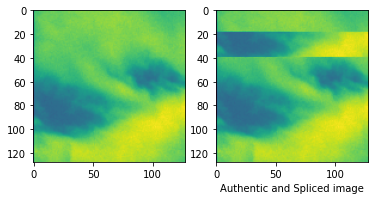

In [56]:
#Display the authentic and Spliced input images

img_auth = mpimg.imread(PATH_TO_AUTHENTIC_IMG)
img_spl = mpimg.imread(PATH_TO_SPLICED_IMG)

f,axarr = plt.subplots(1,2);
axarr[0].imshow(img_auth);

axarr[1].imshow(img_spl);
plt.xlabel('Authentic and Spliced image');

plt.show()

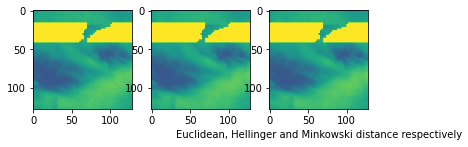

In [57]:
# Display the output images (spliced part colored)

img_euclidean = mpimg.imread('euclidean.bmp')
img_hellinger = mpimg.imread('hellinger.bmp')
img_minkowski = mpimg.imread('minkowski.bmp')

f,axarr = plt.subplots(1,3);

axarr[0].imshow(img_euclidean);
axarr[1].imshow(img_hellinger);
axarr[2].imshow(img_minkowski);

plt.xlabel('Euclidean, Hellinger and Minkowski distance respectively');
plt.show()